# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import camb 
from camb import model
print(f'Using CAMB {camb.__version__} installed at {os.path.dirname(camb.__file__)}')

Using CAMB 1.5.8 installed at /home/gilee/CAMB/camb


In [2]:
os.getcwd()

'/md/gilee/Multiverse/ic_gen/github_repo/Multiverse-IC/notebooks'

In [3]:
def initialize_camb_params(cosmo_params, z):
    
    h = cosmo_params['h']
    Omega_b = cosmo_params['Omega_b']
    Omega_c = cosmo_params['Omega_c']
    Omega_k = cosmo_params['Omega_k']
    w0 = cosmo_params['w0']
    wa = cosmo_params['wa']
    As = cosmo_params['As']
    ns = cosmo_params['ns']
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100*h, ombh2=Omega_b*h*h, omch2=Omega_c*h*h, omk=Omega_k)
    pars.DarkEnergy = camb.dark_energy.DarkEnergyPPF(w=w0, wa=wa)
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_matter_power(redshifts=z, kmax=kmax, k_per_logint=k_per_logint)
    pars.NonLinear = model.NonLinear_none
    
    return pars

```fortran
Signature:
pars.InitPower.set_params(
    As=2e-09,
    ns=0.96,
    nrun=0,
    nrunrun=0.0,
    r=0.0,
    nt=None,
    ntrun=0.0,
    pivot_scalar=0.05,
    pivot_tensor=0.05,
    parameterization='tensor_param_rpivot',
)
Docstring:
Set parameters using standard power law parameterization. If nt=None, uses inflation consistency relation.

:param As: comoving curvature power at k=pivot_scalar (:math:`A_s`)
:param ns: scalar spectral index :math:`n_s`
:param nrun: running of scalar spectral index :math:`d n_s/d \log k`
:param nrunrun: running of running of spectral index, :math:`d^2 n_s/d (\log k)^2`
:param r: tensor to scalar ratio at pivot
:param nt: tensor spectral index :math:`n_t`. If None, set using inflation consistency
:param ntrun: running of tensor spectral index
:param pivot_scalar: pivot scale for scalar spectrum
:param pivot_tensor:  pivot scale for tensor spectrum
:param parameterization: See CAMB notes. One of
    - tensor_param_indeptilt = 1
    - tensor_param_rpivot = 2
    - tensor_param_AT = 3
:return: self
File:      ~/CAMB/camb/initialpower.py
Type:      method
```

**Focus on `As` above.**  
**Focus on `pivot_scalar` above.**

```fortran
Signature:
pars.set_matter_power(
    redshifts=(0.0,),
    kmax=1.2,
    k_per_logint=None,
    nonlinear=None,
    accurate_massive_neutrino_transfers=False,
    silent=False,
)
Docstring:
Set parameters for calculating matter power spectra and transfer functions.

:param redshifts: array of redshifts to calculate
:param kmax: maximum k to calculate (where k is just k, not k/h)
:param k_per_logint: minimum number of k steps per log k. Set to zero to use default optimized spacing.
:param nonlinear: if None, uses existing setting, otherwise boolean for whether to use non-linear matter power.
:param accurate_massive_neutrino_transfers: if you want the massive neutrino transfers accurately
:param silent: if True, don't give warnings about sort order
:return: self
File:      ~/CAMB/camb/model.py
Type:      method
```

**Focus on `kmax` above.**  
**Focus on `k_per_logint` above.** 

In [4]:
def adjust_As_at_z0(pars, cosmo_params, tolerance=1e-20, max_iterations=1000):
    
    z0 = pars.Transfer.PK_redshifts[0]
    
    if z0 != 0:
        print(f"Redshift should be 0 here.")
        return None
    
    iteration = 0
    
    results = camb.get_results(pars)
    sigma8 = results.get_sigma8()
    target_sigma8 = cosmo_params['sigma8_z0_WMAP5']
    
    print(f"Target sigma8 = {target_sigma8} at z = {z0} (tolerance = {tolerance})")
    print(f"Iteration {iteration}: sigma8 = {sigma8[0]}, diff={target_sigma8 - sigma8[0]}, As = {pars.InitPower.As} (trial)")
    
    while (np.abs(target_sigma8 - sigma8[0]) > tolerance) and (iteration < max_iterations):
        
        iteration += 1
        As = pars.InitPower.As * (target_sigma8 / sigma8[0])**2 # new normalization
        pars.InitPower.set_params(As=As, ns=pars.InitPower.ns)
        
        # Get new results and sigma8 value
        results = camb.get_results(pars)
        sigma8 = results.get_sigma8()
        print(f"Iteration {iteration}: sigma8 = {sigma8[0]}, diff={target_sigma8 - sigma8[0]}, As = {pars.InitPower.As}")
        
        
    if iteration >= max_iterations:
        print("Warning: Maximum iterations reached. The tolerance may be too strict.")
    else:
        print("Converged successfully!")
        cosmo_params['As'] = As
        print("As updated in cosmo_params.")
            
    return pars

# Cosmological Parameters (WMAP5)

In [5]:
bias8_z0_WMAP5  = 1.26             # target value
sigma8_z0_WMAP5 = 1/bias8_z0_WMAP5 # target value # sigma8 at z=0

As0       = 2e-9                   # trial value # power spectrum noramlization factor at k=k0
ns        = 0.96                   # power spectral index
h         = 0.72                   # little h, dimensionless hubble parameter, H0 = 100*h [km/s/Mpc]

Omega_m   = 0.26                   # physical total matter density
Omega_b   = 0.044                  # physical baryon density
Omega_c   = Omega_m - Omega_b      # physical CDM (cold dark mattery) density
Omega_l   = 1 - Omega_m            # DE (dark energy) density
Omega_k   = 0.0                    # spatial curvature, omk = 1 - omt

# EoS of DE
w0 = -1
wa = 0

In [6]:
# Cosmological Parameters (WMAP5)
cosmo_params = {
    'As': As0, # trial number
    'ns': ns,
    'h': h,
    'bias8_z0_WMAP5': bias8_z0_WMAP5,
    'Omega_m': Omega_m,
    'Omega_b': Omega_b,
    'Omega_k': Omega_k,
    'w0': w0,
    'wa': wa
}

cosmo_params['sigma8_z0_WMAP5'] = 1/cosmo_params['bias8_z0_WMAP5']
cosmo_params['Omega_c'] = cosmo_params['Omega_m'] - cosmo_params['Omega_b']
cosmo_params['Omega_l'] = 1 - cosmo_params['Omega_m']

In [7]:
cosmo_params

{'As': 2e-09,
 'ns': 0.96,
 'h': 0.72,
 'bias8_z0_WMAP5': 1.26,
 'Omega_m': 0.26,
 'Omega_b': 0.044,
 'Omega_k': 0.0,
 'w0': -1,
 'wa': 0,
 'sigma8_z0_WMAP5': 0.7936507936507936,
 'Omega_c': 0.21600000000000003,
 'Omega_l': 0.74}

In [8]:
print("\nWMAP5 Parameters:")
print("  bias8 = ", bias8_z0_WMAP5)
print("  sigma8 = ", sigma8_z0_WMAP5)
print("  Omega_m = ", Omega_m)
print("  Omega_b = ", Omega_b)
print("  Omega_c = ", Omega_c)
print("  Omega_l = ", Omega_l)
print("  Omega_k = ", Omega_k)
print("  w0 = ", w0)
print("  wa = ", wa)


WMAP5 Parameters:
  bias8 =  1.26
  sigma8 =  0.7936507936507936
  Omega_m =  0.26
  Omega_b =  0.044
  Omega_c =  0.21600000000000003
  Omega_l =  0.74
  Omega_k =  0.0
  w0 =  -1
  wa =  0


In [9]:
# starting redshift
z_start = 200
a_start = 1/(z_start+1)

# simulation box setups
levelmin = 7
levelmax = levelmin + 7
n_cell0  = 2**levelmin
c_Lbox   = 2**levelmax / 1000 # [cMpc]
c_dx0    = c_Lbox / n_cell0   # [cMpc]

print("\nSimulation Box Setups:")
print("  z_start       = ", z_start)
print("  a_start       = ", a_start)

print("\n  Lbox [cMpc]   = ", c_Lbox)
print("  Lbox [cMpc/h] = ", c_Lbox*h)
print("  dx_ini [ckpc] = ", c_dx0 * 1000)
print("  dx_ini [pkpc] = ", c_dx0 * 1000 / (z_start + 1))
print("  dx_fin [pkpc] = ", c_dx0 * 1000 / 2**7)
print("  levelmin      = ", levelmin)
print("  levelmax      = ", levelmax)
print("  Ncell_ini     = ", n_cell0)

# power spectrum params
kmin = 2 * np.pi / c_Lbox       # [1/Mpc] # largest scale (box size)
kmax = np.pi * n_cell0 / c_Lbox # [1/Mpc] # smallest scale (Nyquist wavenumber)
khmin = kmin/h                  # [1/Mpc] # largest scale (box size)
khmax = kmax/h                  # [1/Mpc] # smallest scale (Nyquist wavenumber)
k0  = 0.05                      # [1/Mpc] pivot_scalar
kh0 = k0/h                      # [1/Mpc] pivot_scalar

k_per_logint = 0 # default: 0 # affects the number of k values

print("\nPower Sepctrum Parameters:")
print("\n  kmin   [1/Mpc] = ", kmin)
print("  kmin/h [1/Mpc] = ", khmin)
print("  kmax   [1/Mpc] = ", kmax)
print("  kmax/h [1/Mpc] = ", khmax)


Simulation Box Setups:
  z_start       =  200
  a_start       =  0.004975124378109453

  Lbox [cMpc]   =  16.384
  Lbox [cMpc/h] =  11.796479999999999
  dx_ini [ckpc] =  128.0
  dx_ini [pkpc] =  0.6368159203980099
  dx_fin [pkpc] =  1.0
  levelmin      =  7
  levelmax      =  14
  Ncell_ini     =  128

Power Sepctrum Parameters:

  kmin   [1/Mpc] =  0.38349519697141027
  kmin/h [1/Mpc] =  0.5326322180158476
  kmax   [1/Mpc] =  24.543692606170257
  kmax/h [1/Mpc] =  34.088461953014246


# The Unit of $L_{box}$ (Simulation Box)

Let $L_{box}$ be the comoving simulation box size with units of Mpc. Then:  
* $L_{box} = L [cMpc]$  
* $L_{box} \times h = L \times h [cMpc]$  
* $L_{box} = L \times h [cMpc/h]$  

These three expressions represent the same quantity in different units.  

# The Unit of $k$ (Wave Number)

The wave number $k$ is defined as:

$k = \frac{2\pi}{\lambda}$

where $\lambda$ is the wavelength with units of Mpc. Then:

* $k   = \frac{2\pi}{\lambda} [Mpc^{-1}]$ : **CAMB**  
* $k   = \frac{2\pi}{\lambda h} [h Mpc^{-1}]$ : **MUSIC**  
* $k/h = \frac{2\pi}{\lambda h} [Mpc^{-1}]$ :**CAMB**  

This clarifies how the wave number $k$ is expressed differently in CAMB and MUSIC.

# Get Matter Power Sepctrum

In [10]:
pars   = initialize_camb_params(cosmo_params, z=[0]) # initialize
pars   = adjust_As_at_z0(pars, cosmo_params) # normalization

Target sigma8 = 0.7936507936507936 at z = 0.0 (tolerance = 1e-20)
Iteration 0: sigma8 = 0.7628693474928043, diff=0.03078144615798928, As = 2e-09 (trial)
Iteration 1: sigma8 = 0.7936507936507937, diff=-1.1102230246251565e-16, As = 2.1646544338903376e-09
Iteration 2: sigma8 = 0.7936507936507937, diff=-1.1102230246251565e-16, As = 2.164654433890337e-09
Iteration 3: sigma8 = 0.7936507936507936, diff=0.0, As = 2.1646544338903368e-09
Converged successfully!
As updated in cosmo_params.


In [11]:
As = cosmo_params['As']
As, pars.InitPower.As, As - pars.InitPower.As # just for checking

(2.1646544338903368e-09, 2.1646544338903368e-09, 0.0)

In [12]:
pars = initialize_camb_params(cosmo_params, z=[200])
results = camb.get_results(pars)

In [13]:
results.get_sigma8()

array([0.00548385])

## 1. Built-in function: `get_matter_power_spectrum`

In [14]:
kh, z, Pkh_t = results.get_matter_power_spectrum(minkh=khmin, maxkh=khmax, var1='delta_nonu', var2='delta_nonu')
kh, z, Pkh_c = results.get_matter_power_spectrum(minkh=khmin, maxkh=khmax, var1='delta_cdm', var2='delta_cdm')
kh, z, Pkh_b = results.get_matter_power_spectrum(minkh=khmin, maxkh=khmax, var1='delta_baryon', var2='delta_baryon')
kh, z, Pkh_vc = results.get_matter_power_spectrum(minkh=khmin, maxkh=khmax, var1='v_newtonian_cdm', var2='v_newtonian_cdm')
kh, z, Pkh_vb = results.get_matter_power_spectrum(minkh=khmin, maxkh=khmax, var1='v_newtonian_baryon', var2='v_newtonian_baryon')

# [kh]  = 1/Mpc
# [Pkh] = h^-3 Mpc^3 (from the camb python documentation)

``` fortran
Signature:
results.get_matter_power_spectrum(
    minkh=0.0001,
    maxkh=1.0,
    npoints=100,
    var1=None,
    var2=None,
    have_power_spectra=False,
    params=None,
)
Docstring:
Calculates :math:`P_{xy}(k/h)`, where x, y are one of Transfer_cdm, Transfer_xx etc.
The output k values are regularly log spaced and interpolated. If NonLinear is set, the result is non-linear.

For a description of outputs for different var1, var2 see :ref:`transfer-variables`.

:param minkh: minimum value of k/h for output grid (very low values < 1e-4 may not be calculated)
:param maxkh: maximum value of k/h (check consistent with input params.Transfer.kmax)
:param npoints: number of points equally spaced in log k
:param var1: variable i (index, or name of variable; default delta_tot)
:param var2: variable j (index, or name of variable; default delta_tot)
:param have_power_spectra: set to True if already computed power spectra
:param params: if have_power_spectra=False and want to specify new parameters,
               a :class:`~.model.CAMBparams` instance
:return: kh, z, PK, where kz and z are arrays of k/h and z respectively, and PK[i,j] is value at z[i], k/h[j]
File:      ~/CAMB/camb/results.py
Type:      method
```

The unit of `Pkh` is (Mpc/h)^3.

Ref: https://camb.readthedocs.io/en/latest/camb.html#camb.get_matter_power_interpolator

```python
from camb import get_matter_power_interpolator
PK = get_matter_power_interpolator(params);
print('Power spectrum at z=0.5, k/h=0.1/Mpc is %s (Mpc/h)^3 '%(PK.P(0.5, 0.1)))
```

In [15]:
kh.shape # = npoints

(100,)

In [16]:
khmax, kh.max(), khmax - kh.max() # just for checking

(34.088461953014246, 34.08846195301423, 1.4210854715202004e-14)

In [17]:
khmin, kh.min(), khmin - kh.min() # just for checking

(0.5326322180158476, 0.5326322180158476, 0.0)

## 2. Built-in function: `get_matter_power_interpolator`

In [18]:
args = dict(zmin=0, zmax=500, kmax=kmax, nonlinear=False)#, hubble_units=False, k_hunit=False)
iPkh_t = camb.get_matter_power_interpolator(pars, var1='delta_nonu', var2='delta_nonu', **args)
iPkh_c = camb.get_matter_power_interpolator(pars, var1='delta_cdm', var2='delta_cdm', **args)
iPkh_b = camb.get_matter_power_interpolator(pars, var1='delta_baryon', var2='delta_baryon', **args)
iPkh_vc = camb.get_matter_power_interpolator(pars, var1='v_newtonian_cdm', var2='v_newtonian_cdm', **args)
iPkh_vb = camb.get_matter_power_interpolator(pars, var1='v_newtonian_baryon', var2='v_newtonian_baryon', **args)

# hubble_units = True:  P [h^3 Mpc^3] (default)
# hubble_units = False: P [Mpc^3]
# k_hunit = True:  k/h [Mpc^{-1}] (default)
# k_hunit = False: k   [Mpc^{-1}]

```fortran
Signature:
camb.get_matter_power_interpolator(
    params,
    zmin=0,
    zmax=10,
    nz_step=100,
    zs=None,
    kmax=10,
    nonlinear=True,
    var1=None,
    var2=None,
    hubble_units=True,
    k_hunit=True,
    return_z_k=False,
    k_per_logint=None,
    log_interp=True,
    extrap_kmax=None,
)
Docstring:
Return a 2D spline interpolation object to evaluate matter power spectrum as function of z and k/h, e.g.

.. code-block:: python

   from camb import get_matter_power_interpolator
   PK = get_matter_power_interpolator(params);
   print('Power spectrum at z=0.5, k/h=0.1/Mpc is %s (Mpc/h)^3 '%(PK.P(0.5, 0.1)))

For a description of outputs for different var1, var2 see :ref:`transfer-variables`.

This function re-calculates results from scratch with the given parameters.
If you already have a :class:`~.results.CAMBdata` result object, you should instead
use :meth:`~.results.CAMBdata.get_matter_power_interpolator`
(call :meth:`.model.CAMBparams.set_matter_power` as need to set up the required ranges for the matter power
before calling get_results).

:param params: :class:`.model.CAMBparams` instance
:param zmin: minimum z (use 0 or smaller than you want for good interpolation)
:param zmax: maximum z (use larger than you want for good interpolation)
:param nz_step: number of steps to sample in z (default max allowed is 100)
:param zs: instead of zmin,zmax, nz_step, can specific explicit array of z values to spline from
:param kmax: maximum k
:param nonlinear: include non-linear correction from halo model
:param var1: variable i (index, or name of variable; default delta_tot)
:param var2: variable j (index, or name of variable; default delta_tot)
:param hubble_units: if true, output power spectrum in :math:`({\rm Mpc}/h)^{3}` units,
                     otherwise :math:`{\rm Mpc}^{3}`
:param k_hunit: if true, matter power is a function of k/h, if false, just k (both :math:`{\rm Mpc}^{-1}` units)
:param return_z_k: if true, return interpolator, z, k where z, k are the grid used
:param k_per_logint: specific uniform sampling over log k (if not set, uses optimized irregular sampling)
:param log_interp: if true, interpolate log of power spectrum (unless any values are negative in which case ignored)
:param extrap_kmax: if set, use power law extrapolation beyond kmax to extrap_kmax (useful for tails of integrals)
:return: An object PK based on :class:`~scipy:scipy.interpolate.RectBivariateSpline`, that can be called
         with PK.P(z,kh) or PK(z,log(kh)) to get log matter power values.
         If return_z_k=True, instead return interpolator, z, k where z, k are the grid used.
File:      ~/CAMB/camb/camb.py
Type:      function
```

## 3. Directly computed from transfer function

In [19]:
transfers = results.get_matter_transfer_data()
# Get matter transfer function data and sigma8 for calculated results.

`transfers?`

```fortran
Type:        MatterTransferData
String form: <camb.results.MatterTransferData object at 0x7f9597efb550>
File:        ~/CAMB/camb/results.py
Docstring:  
MatterTransferData is the base class for storing matter power transfer function data for various q values. In a flat universe q=k, in a closed universe q is quantized.

To get an instance of this data, call :meth:`.results.CAMBdata.get_matter_transfer_data`.

For a description of the different Transfer_xxx outputs (and 21cm case) see :ref:`transfer-variables`; the array is indexed by index+1 given by:

- Transfer_kh = 1 (k/h)
- Transfer_cdm = 2 (cdm)
- Transfer_b = 3 (baryons)
- Transfer_g = 4 (photons)
- Transfer_r = 5 (massless neutrinos)
- Transfer_nu = 6 (massive neutrinos)
- Transfer_tot = 7 (total matter)
- Transfer_nonu = 8 (total matter excluding neutrinos)
- Transfer_tot_de = 9 (total including dark energy perturbations)
- Transfer_Weyl = 10 (Weyl potential)
- Transfer_Newt_vel_cdm = 11 (Newtonian CDM velocity)
- Transfer_Newt_vel_baryon = 12 (Newtonian baryon velocity)
- Transfer_vel_baryon_cdm = 13 (relative baryon-cdm velocity)


:ivar nq:  number of q modes calculated
:ivar q: array of q values calculated
:ivar sigma_8: array of :math:`\sigma_8` values for each redshift
:ivar sigma2_vdelta_8: array of v-delta8 correlation, so sigma2_vdelta_8/sigma_8 can define growth
:ivar transfer_data: numpy array T[entry, q_index, z_index] storing transfer functions for each redshift and q;
                     entry+1 can be one of the Transfer_xxx variables above.
```

In [20]:
S8 = transfers.sigma_8
S8 # just for checking

array([0.00548385])

In [21]:
T = transfers.transfer_data

In [22]:
T.shape

(13, 217, 1)

In [23]:
trans_kh = T[0, :, 0]  # = k/h   [1/Mpc]
Tc       = T[1, :, 0]  # cdm     [dimensionless]
Tb       = T[2, :, 0]  # baryon  [dimensionless]
# Tt       = T[6, :, 0]  # total   [dimensionless] # including neutrinos
Tt       = T[7, :, 0]  # total   [dimensionless] # excluding neutrinos
Tvc      = T[10, :, 0] # vcdm    [dimensionless]
Tvb      = T[11, :, 0] # vbaryon [dimensionless]

In [24]:
trans_kh.min(), khmin # different

(9.729077e-06, 0.5326322180158476)

In [25]:
trans_kh.max(), khmax # slightly different

(35.792885, 34.088461953014246)

**Questions:**

- **How is `trans_kh.min()` determined?**  
- **How is the number of `trans_kh` values determined?** &rarr; `k_per_logint` in `pars.set_matter_power` function
- **How does `k_per_logint` work and determin the number of k values exactly?**

```fortran
Signature:
pars.set_matter_power(
    redshifts=(0.0,),
    kmax=1.2,
    k_per_logint=None,
    nonlinear=None,
    accurate_massive_neutrino_transfers=False,
    silent=False,
)
Docstring:
Set parameters for calculating matter power spectra and transfer functions.

:param redshifts: array of redshifts to calculate
:param kmax: maximum k to calculate (where k is just k, not k/h)
:param k_per_logint: minimum number of k steps per log k. Set to zero to use default optimized spacing.
:param nonlinear: if None, uses existing setting, otherwise boolean for whether to use non-linear matter power.
:param accurate_massive_neutrino_transfers: if you want the massive neutrino transfers accurately
:param silent: if True, don't give warnings about sort order
:return: self
File:      ~/CAMB/camb/model.py
Type:      method
```
**With the above documentation, it is hard to understand how does it determine**
1. **the minimum value `k`,**
2. **the values of `k`, and**
3. **the numbers of `k`.**

**Therefore, I need to look into the source code. For now, I will leave it for later due to time constraints.**

In [26]:
def compute_camb_Pk(kh, T):
    """
    Ref: Cell [52] in https://camb.readthedocs.io/en/latest/CAMBdemo.html
    """  
    k = kh*h # [1/Mpc]
    primordial_PK = results.Params.scalar_power(k)
#     primordial_PK = As * (k/k0)**(ns-1)
    Pk = primordial_PK * T*T * k * 2*np.pi*np.pi *h*h*h # [h^{-3} Mpc^3]
    return Pk

Ref: Cell [52] in https://camb.readthedocs.io/en/latest/CAMBdemo.html
```python
#Check we can get the matter power spectrum from the transfer function as expected
k = kh*results.Params.h
transfer = trans.transfer_data[model.Transfer_tot-1,:,0]
primordial_PK = results.Params.scalar_power(k)
matter_power = primordial_PK*transfer**2*k**4 / (k**3/(2*np.pi**2))

#compare with CAMB's explicit output for the matter power spectrum
kh2,zs,PK = results.get_linear_matter_power_spectrum(hubble_units=False)

plt.loglog(kh,matter_power)
plt.loglog(kh, PK[0,:]);
plt.xlabel(r'$k\, [h Mpc^{-1}]$');
```

In [27]:
trans_Pt = compute_camb_Pk(trans_kh, Tt) # [h^{-3} Mpc^3]
trans_Pc = compute_camb_Pk(trans_kh, Tc) # [h^{-3} Mpc^3]
trans_Pb = compute_camb_Pk(trans_kh, Tb) # [h^{-3} Mpc^3]
trans_Pvc = compute_camb_Pk(trans_kh, Tvc) # [h^{-3} Mpc^3]
trans_Pvb = compute_camb_Pk(trans_kh, Tvb) # [h^{-3} Mpc^3]

# Compare the Power Spectra

In [28]:
def plot_power_spectra(set_type_):

    if set_type_ == 'total': 
        title_ = 'CDM + Baryon'
        type_ = 't'
    elif set_type_ == 'cdm': 
        title_ = 'CDM'
        type_ = 'c'
    elif set_type_ == 'baryon': 
        title_ = 'Baryon'
        type_ = 'b'
    elif set_type_ == 'vcdm': 
        title_ = 'vCDM'
        type_ = 'vc'
    elif set_type_ == 'vbaryon': 
        title_ = 'vBaryon'
        type_ = 'vb'
    else:
        err_message  = "Invalid 'set_type_' value.\n"
        err_message += "Available 'set_type_': \n"
        err_message += "  total, cdm, baryon, vcdm, vbaryon\n"
        raise ValueError(err_message)

    x1 = trans_kh
    x2 = kh
    x3 = trans_kh
    
    try:
        P1 = globals()[f"iPkh_{type_}"].P(z[0], x1)
        P2 = globals()[f"Pkh_{type_}"][0]
        P3 = globals()[f"trans_P{type_}"]
    except KeyError as e:
        print(f"Error: {e}. Make sure the required global variables are defined.")
        return None

    # Plot
    fig, ax = plt.subplots(2, 1, figsize=(5.5, 8), gridspec_kw={'height_ratios': [3, 1]})
    ax[0].loglog(x1, P1, c='k', label=r"$P_{1}$: get_matter_power_interpolator")
    ax[0].loglog(x2, P2, c='r', ls="--", label=r'$P_{2}$: get_matter_power_spectrum')
    ax[0].loglog(x3, P3, c='b', ls=":", label=r'$P_{3}$: directly computed from $T(k/h)$')
    ax[0].axvline(khmin, ls="--", lw=1, c='k')
    ax[0].axvline(khmax, ls="--", lw=1, c='k')
    ax[0].set_xlabel(r"$k/h$ [Mpc$^{-1}$]")
    ax[0].set_ylabel(r"$P(k/h)$ [$h^{-3}$Mpc$^{3}$]") 
    ax[0].legend(title=f"z = {z[0]}", fontsize=13, title_fontsize=15)
    ax[0].grid(ls=":")

    ax[1].semilogx(x3, P3 / globals()[f"iPkh_{type_}"].P(z[0], x3) - 1, c='b', label=r"$P_3/P_1 - 1$")
    ax[1].semilogx(x2, P2 / globals()[f"iPkh_{type_}"].P(z[0], x2) - 1, c='r', label=r"$P_2/P_1 - 1$")
    ax[1].axvline(khmin, ls="--", lw=1, c='k')
    ax[1].axvline(khmax, ls="--", lw=1, c='k')
    ax[1].set_ylim(-1e-6, 2e-6)
    ax[1].set_xlabel(r"$k/h$ [Mpc$^{-1}$]")
    ax[1].set_ylabel(r"$\delta_P$")
    ax[1].grid(ls=":")
    ax[1].legend(ncols=2, fontsize=13, title_fontsize=15)

    ax[0].set_title(title_)
    plt.tight_layout(pad=0.3)
    plt.show()


<IPython.core.display.Javascript object>


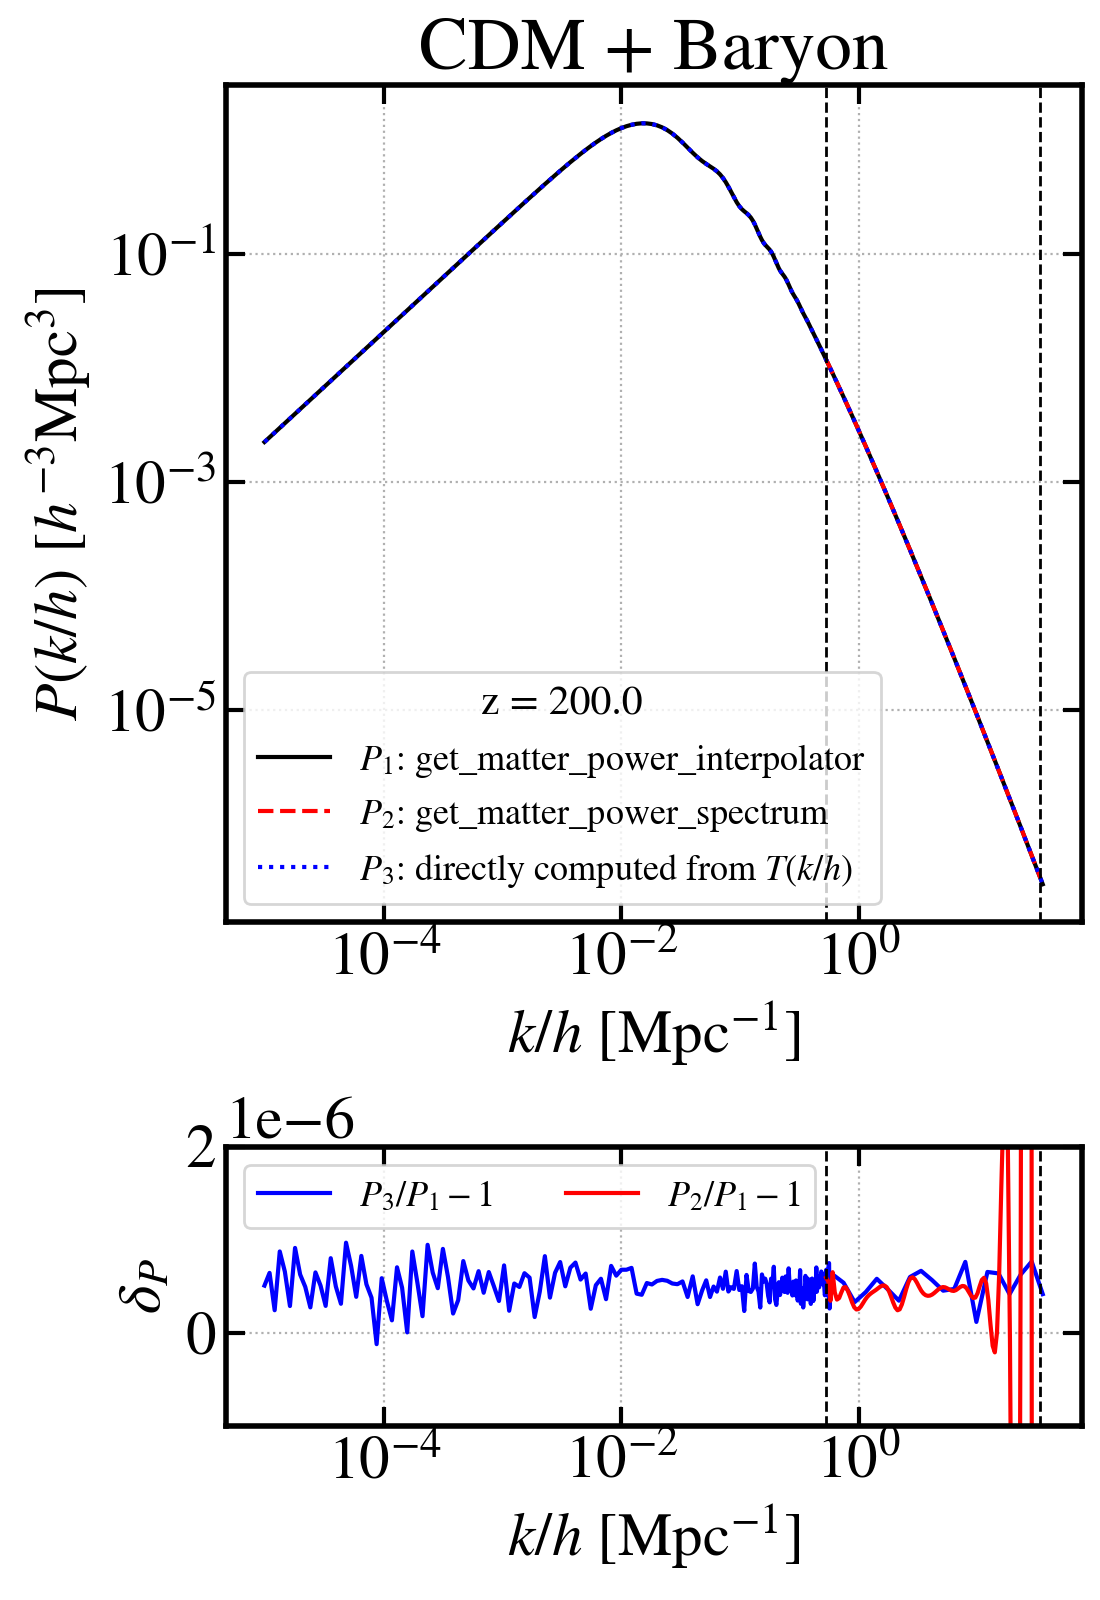

In [29]:
plot_power_spectra("total")

<IPython.core.display.Javascript object>


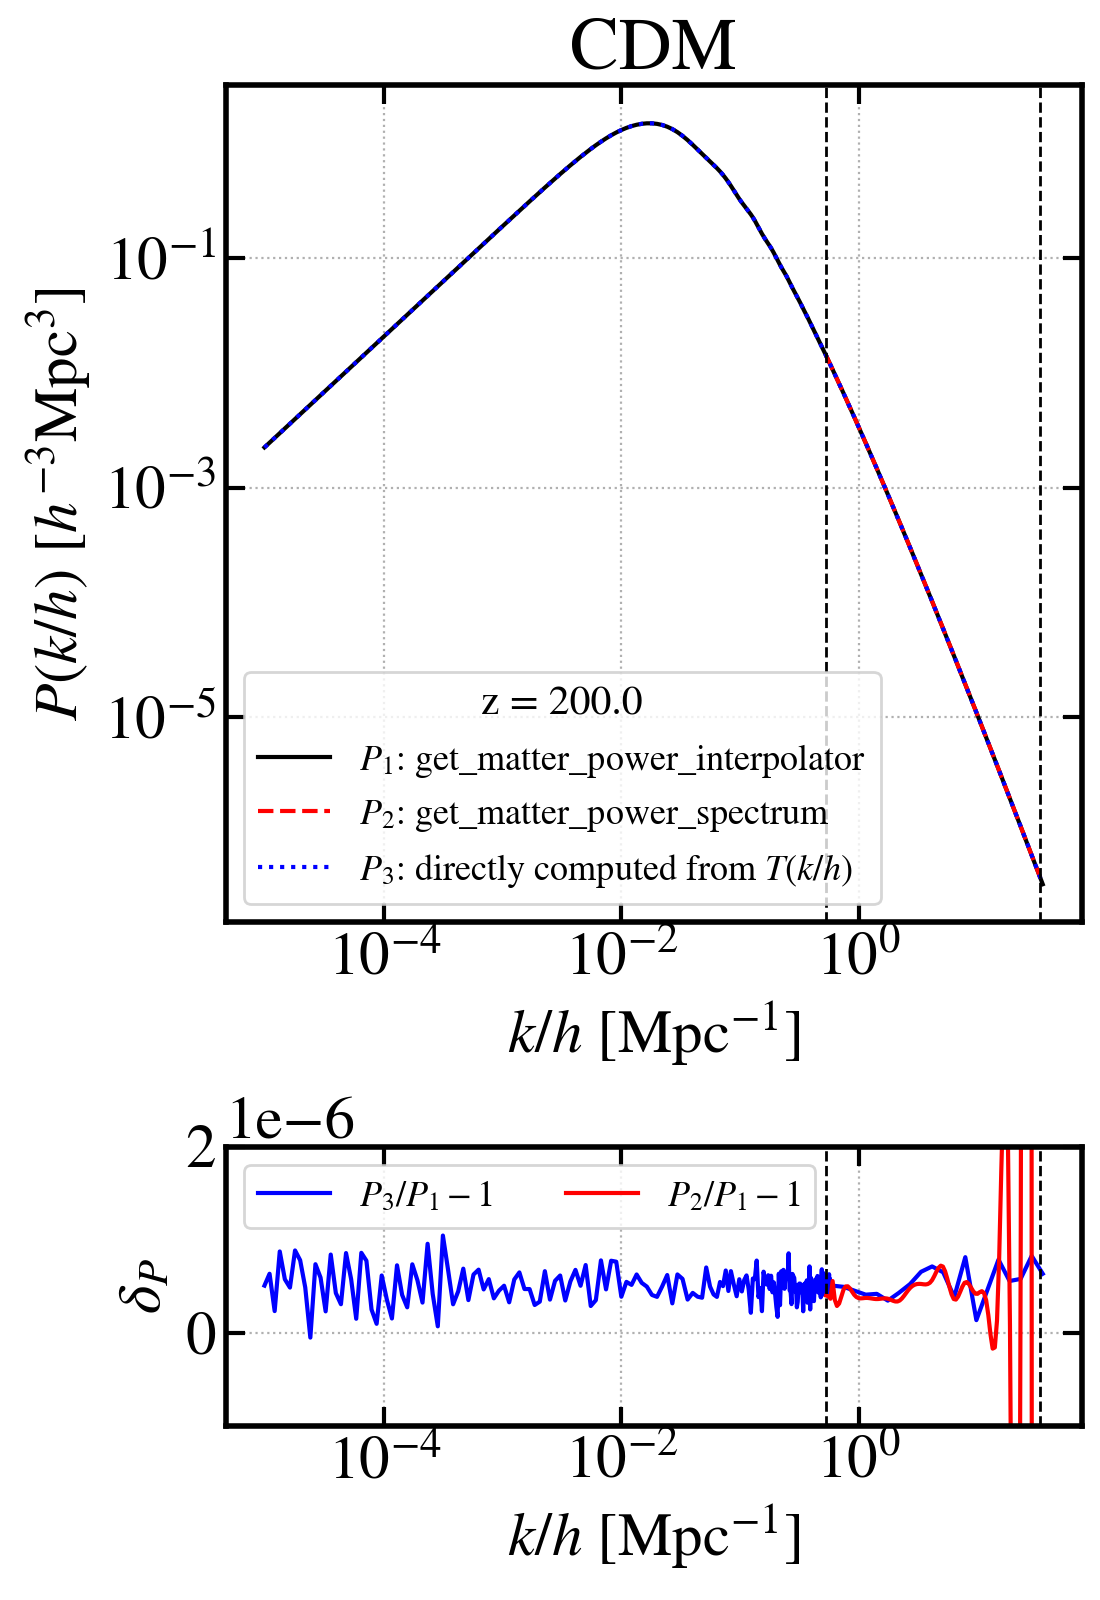

In [30]:
plot_power_spectra("cdm")

<IPython.core.display.Javascript object>


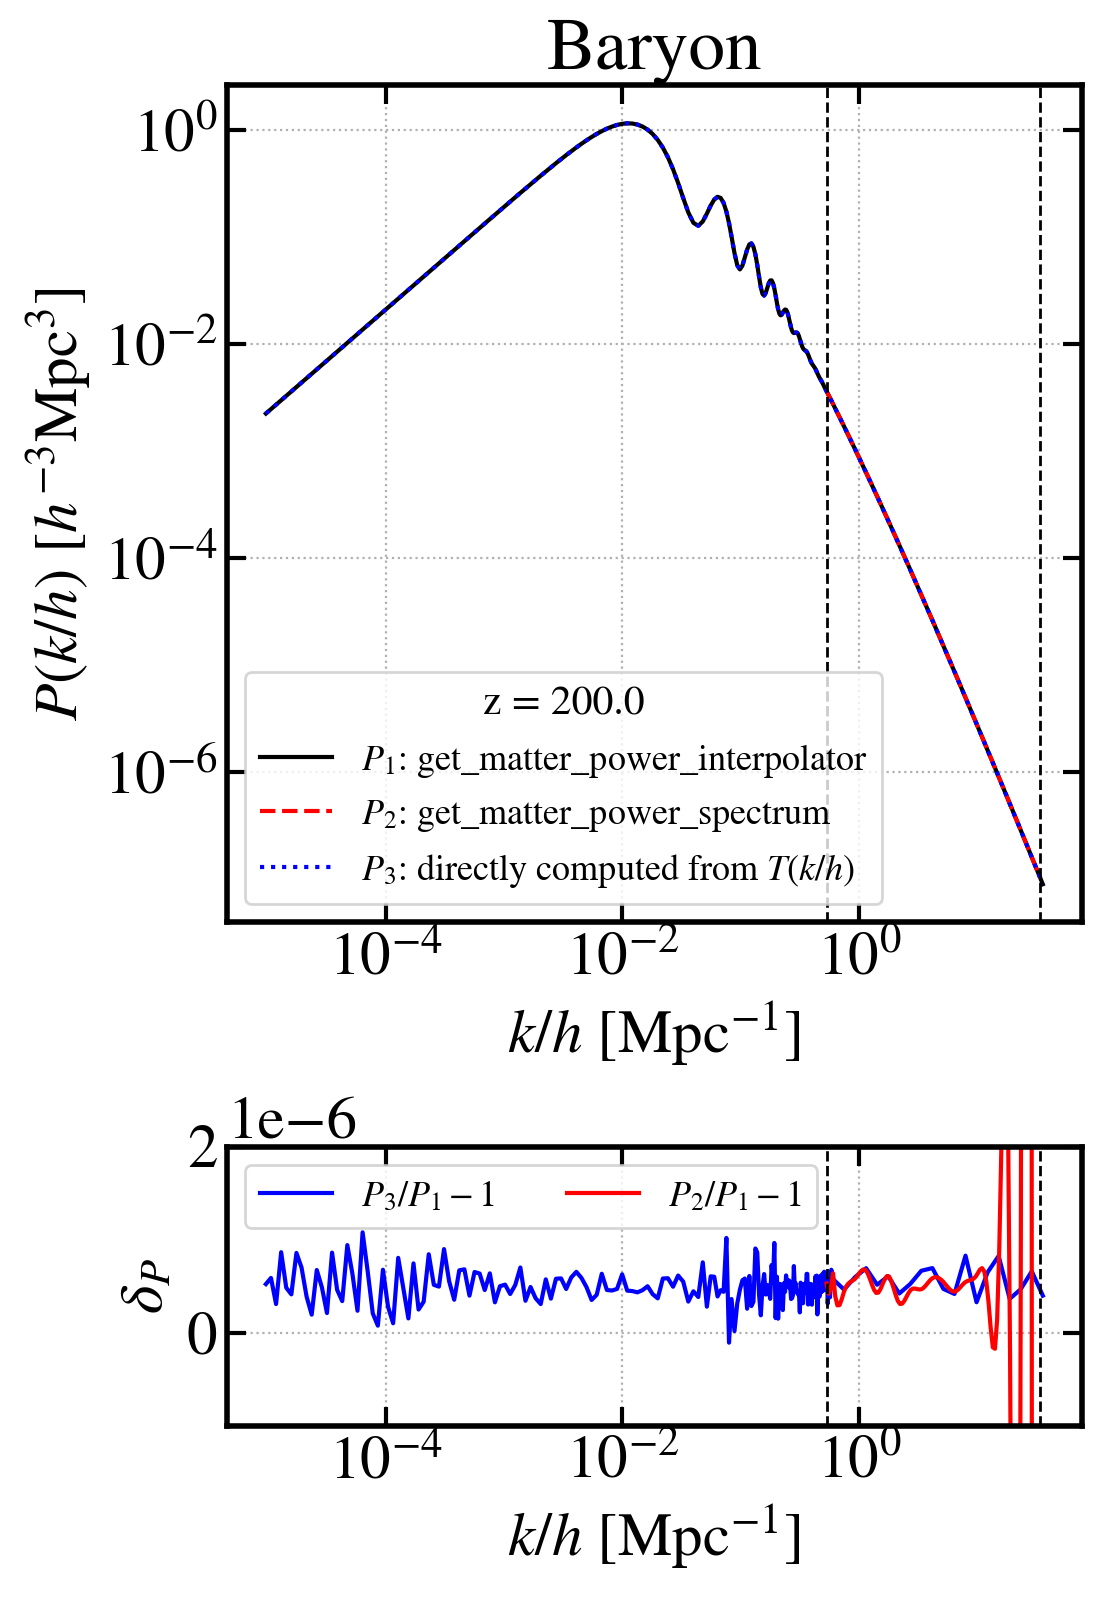

In [31]:
plot_power_spectra("baryon")

<IPython.core.display.Javascript object>


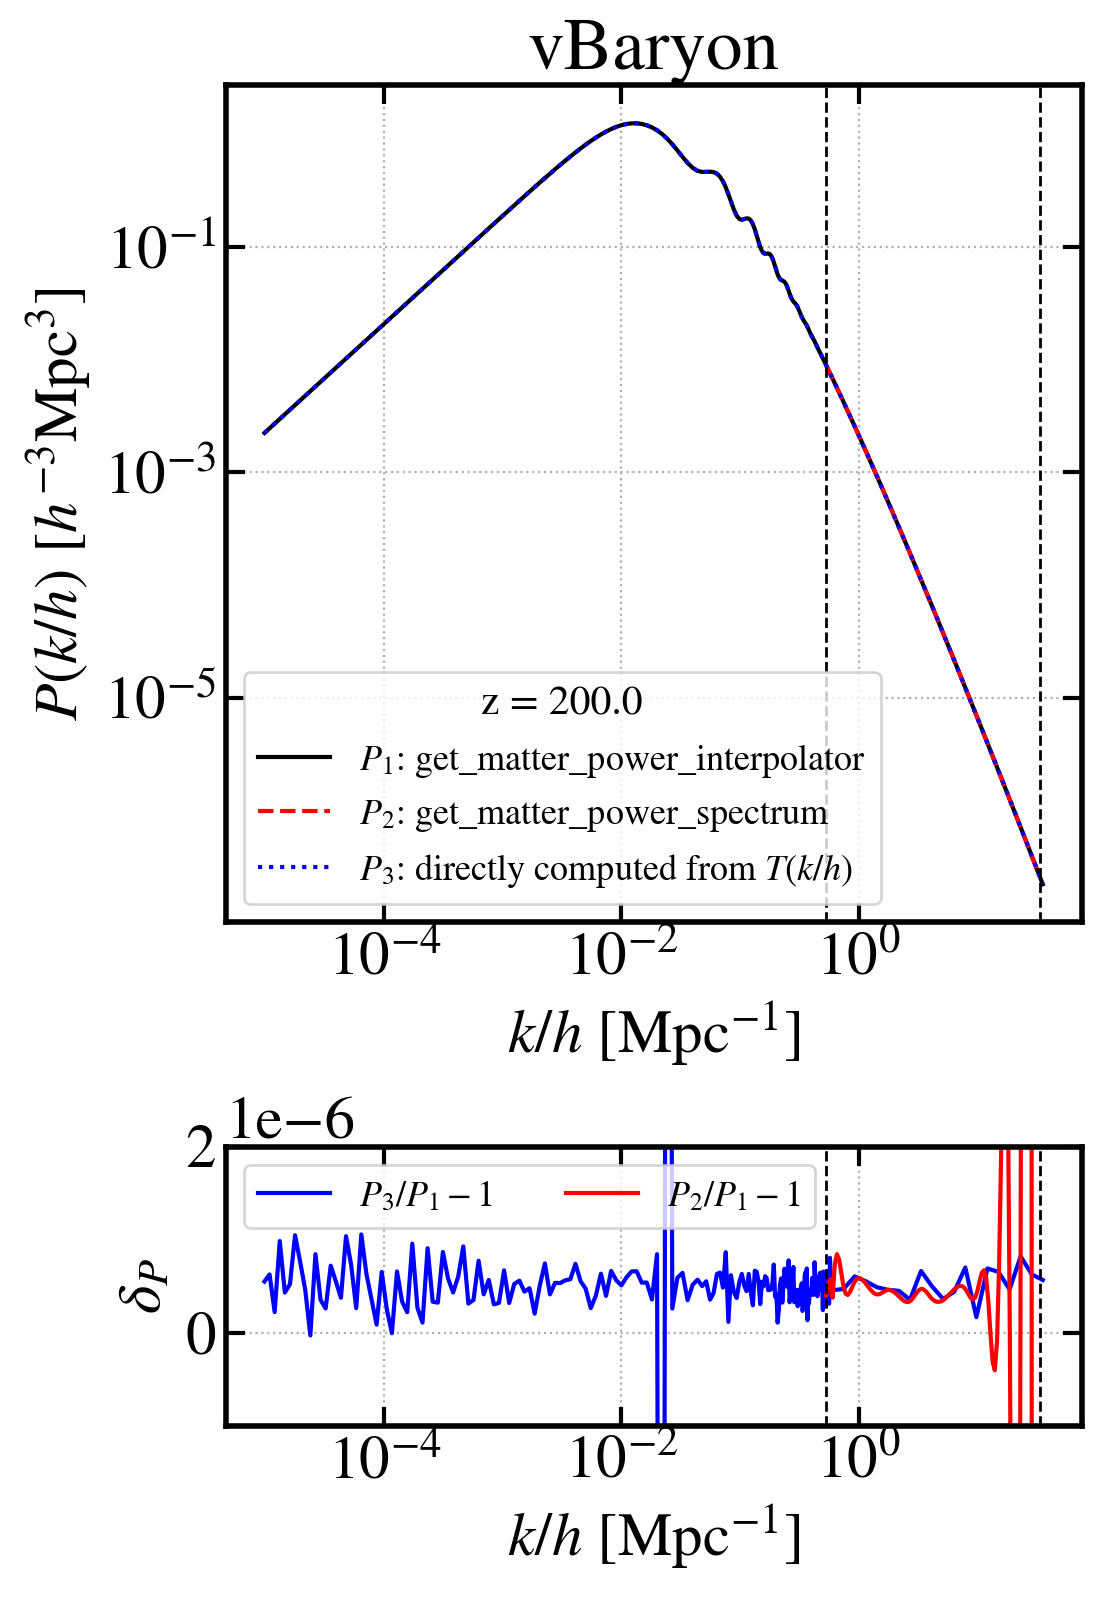

In [32]:
plot_power_spectra("vbaryon")

<IPython.core.display.Javascript object>


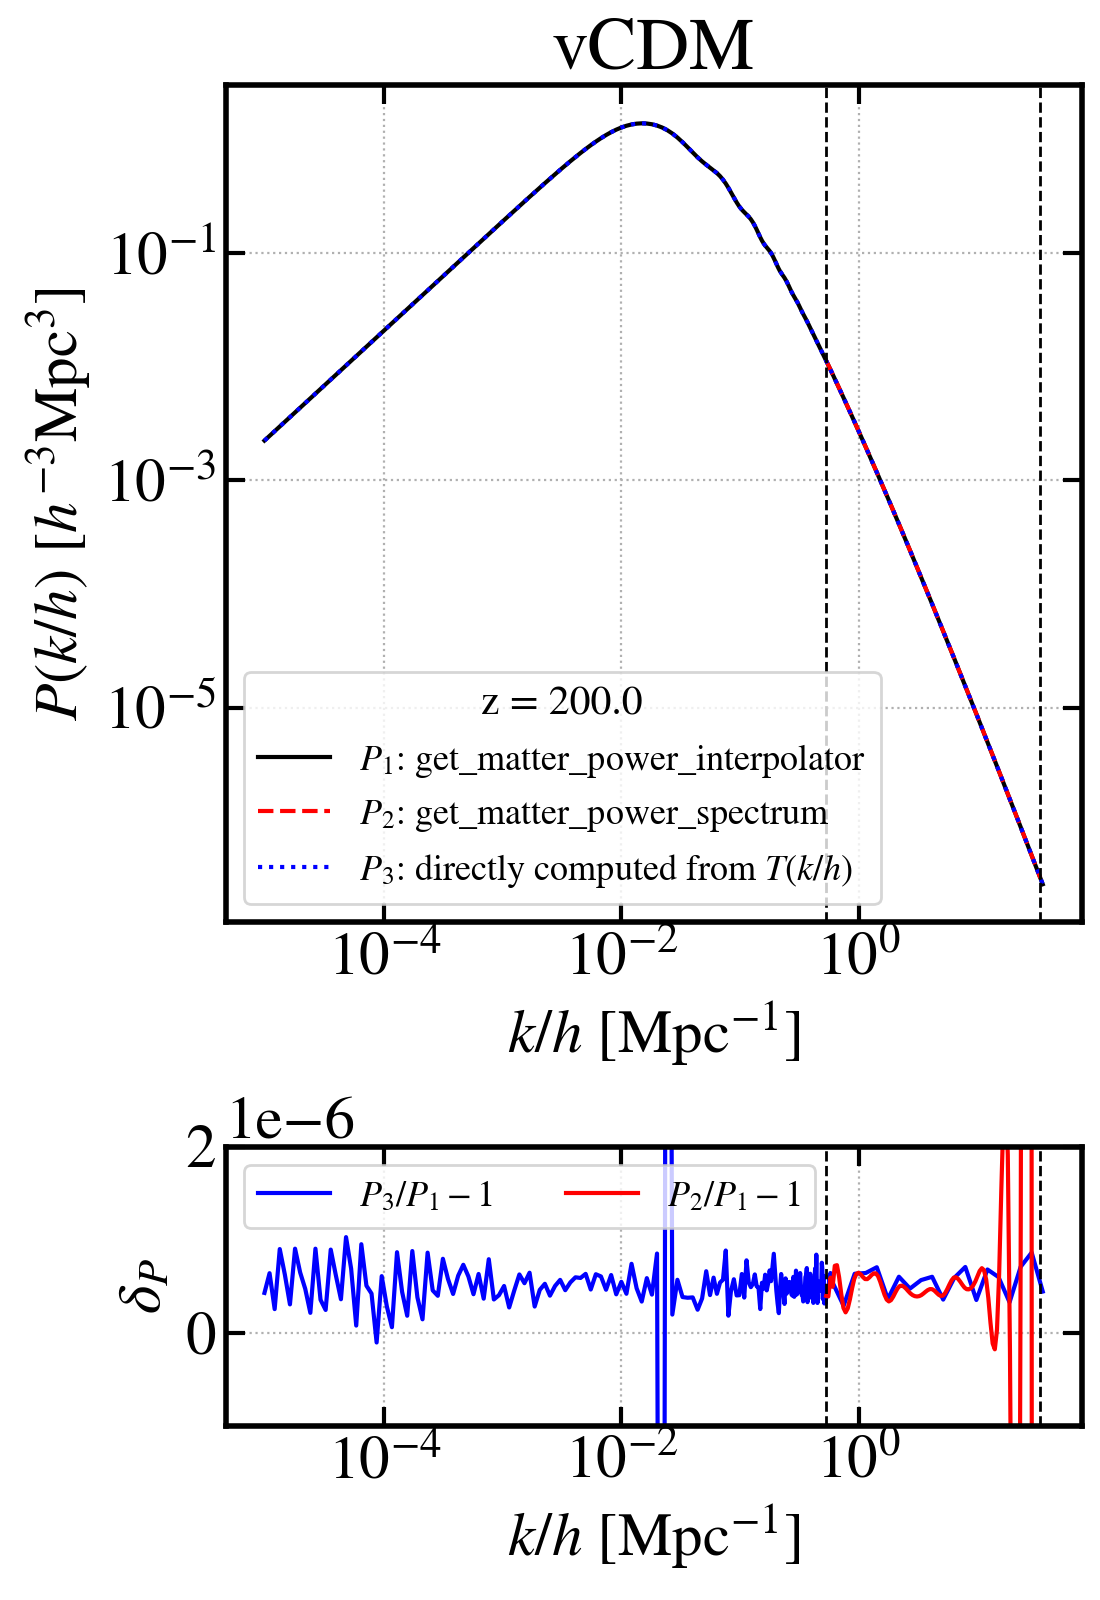

In [33]:
plot_power_spectra("vcdm")

# Then, how to input the CAMB results to MUSIC?

```shell
vi $MUSIC/src/plugins/transfer_camb.cc
```

    (...)

```c++
        std::stringstream ss(line);

        double k, Tkc, Tkb, Tktot, Tkvtot, Tkvc, Tkvb, dummy;

        ss >> k;
        ss >> Tkc;   // cdm
        ss >> Tkb;   // baryon
        ss >> dummy; // photon
        ss >> dummy; // nu
        ss >> dummy; // mass_nu
        ss >> Tktot; // total
        ss >> dummy; // no_nu
        ss >> dummy; // total_de
        ss >> dummy; // Weyl
        ss >> Tkvc;  //>[150609SH: add] // v_cdm
        ss >> Tkvb;  //>[150609SH: add] // v_b
        ss >> dummy; // v_b-v_cdm

        if( ss.bad() || ss.fail() ){
          LOGERR("Error reading the transfer function file (corrupt or not in expected format)!");
          throw std::runtime_error("Error reading transfer function file \'" +
                                   m_filename_Tk + "\'");
        }

```

- **It has the same information with `T` (`transfers.transfer_data`)!**
- **How do MUSIC deal with the `dummy` variables?**
- **What is the meaning of `Tkvc` & `Tkvb`? How do they differ from `Tc` & `Tb`?**

# Save the MUSIC Input File (Transfer Function Table)

In [34]:
plus_w0 = '+' if w0 >= 0 else ''
plus_wa = '+' if wa >= 0 else ''
fname = f"camb_transfer_z{z[0]:03.0f}_w0{plus_w0}{w0:.1f}_wa{plus_wa}{wa:.1f}_klogint{k_per_logint}.txt"
np.savetxt(f"./{fname}", T.reshape(T.shape[:2]).T, fmt="%.10e")
print(f"MUSIC input data is created: ./{fname}")

MUSIC input data is created: ./camb_transfer_z200_w0-1.0_wa+0.0_klogint0.txt
